In [63]:
import argparse
import subprocess
import os
import json
import shutil
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from time import sleep
import concurrent.futures
from matplotlib.patches import Patch

def load_data(input_dir):

    def stats_type_from_file_name(file_name):
        return file_name.split("_")[-1].split(".")[0]
    records = []
    for f in os.listdir(input_dir):
        if f.endswith(".json"):
            with open(os.path.join(input_dir, f)) as json_f:
                records.extend(json.load(json_f)[1:])
    df = pd.DataFrame(records)
    df['time_per_column'] = df['metadata_end_to_end_load_time_nanos'] / df['column_cnt']
    df['stats'] = df.apply(lambda x: stats_type_from_file_name(x['file_name']), axis=1)
    return df

In [76]:
input_dir =  "../target/wide_table_bench/"

df_no_stats_mimalloc_simd = load_data(input_dir + "no_stats_mimalloc_simd")
df_no_stats_mimalloc = load_data(input_dir + "no_stats_mimalloc")
df_new = load_data(input_dir + "no_stats") 
df_old = load_data(input_dir + "old")
# df_simd = load_data(input_dir + "simd")

df_old['variant'] = 'Baseline' 
df_new['variant'] = 'no_stats' 
df_no_stats_mimalloc['variant'] = 'no_stats_mimalloc'
df_no_stats_mimalloc_simd['variant'] = 'no_stats_mimalloc_simd'
# df_simd['variant'] = 'SIMD' 
df = pd.concat([df_new, df_old, df_no_stats_mimalloc])

df['size_per_column'] = df['metadata_len'] / df['column_cnt']
df['bytes_per_ms'] = df['metadata_len'] / (df['metadata_end_to_end_load_time_nanos'] / 1_000_000)

def stats_order(x):
	if x['stats'] == 'none':
		return 1
	if x['stats'] == 'chunk':
		return 2
	if x['stats'] == 'page':
		return 3
df['order'] = df.apply(stats_order, axis=1)
df.sort_values(by='order', inplace=True)

In [77]:
time_per_column = df.groupby('stats')[['time_per_column', 'stats']].describe()['time_per_column']
time_per_column.sort_values(by='mean', ascending=True, inplace=True)

size_per_column = df.groupby('stats')[['size_per_column', 'stats']].describe()['size_per_column']
size_per_column.sort_values(by='mean', ascending=True, inplace=True)

In [78]:
df.groupby('stats')[['time_per_column', 'variant']].describe()

time_per_column                                                    \
                count         mean          std        min          25%   
stats                                                                     
chunk           108.0  6879.446980  1037.328182  5227.2760  6306.751565   
none            108.0  4611.525843   896.223767  3562.2868  3945.553125   
page            108.0  7283.381264  1057.527692  5542.7010  6805.797542   

                                             
              50%          75%          max  
stats                                        
chunk  6701.16700  7570.539725   9869.64480  
none   4379.34773  5074.795950   7278.57164  
page   7004.24000  7877.360750  10484.21900

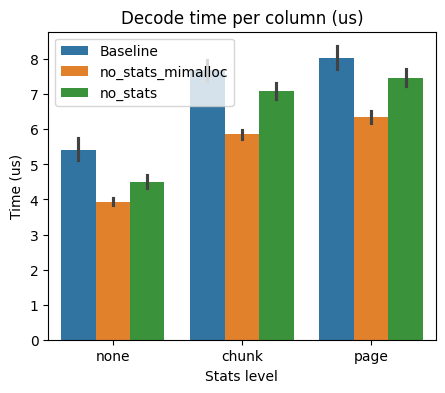

In [79]:
# hue_order = ['Baseline', 'mimalloc' ]

fig, ax1 = plt.subplots(1, 1, figsize=(5, 4))
sns.barplot(x='stats', y='time_per_column', data=df, hue='variant',  ax=ax1)
ax1.set_xlabel('Stats level')
ax1.set_ylabel('Time (us)')
ax1.set_title('Decode time per column (us)')
ax1.legend(title='')
ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: '{:.0f}'.format(x/1e3)))

fig.savefig('mimalloc.png', dpi=300)


In [47]:

decode_time = {
	'file_metadata_decode': 1104 - 625+ 103+96,
	'row_group_metadata_decode': 1792 - 1104 - 442-40-94 + 171+63+30+48+96,
	'memory_allocation': 625 + 442 + 40 +94,
}


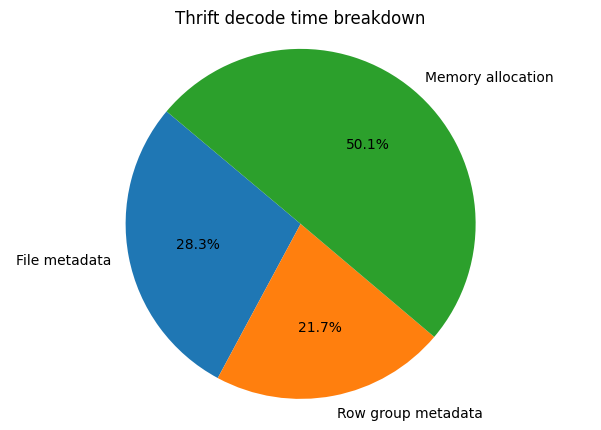

In [48]:
labels_updated = [
    'File metadata',
    'Row group metadata',
    'Memory allocation'
]


# Create lists of keys and values
labels = list(decode_time.keys())
values = list(decode_time.values())

fig, ax1 = plt.subplots(1, 1, figsize=(7.5, 5))
ax1.pie(values, labels=labels_updated, autopct='%1.1f%%', startangle=140)
ax1.set_title('Thrift decode time breakdown')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# Show the plot
plt.show()
fig.savefig('time-decomposition.png', dpi=300)